In [1]:
%%html
<style type="text/css">
.CodeMirror{
        font-size: 18px;
        line-height: 120%;
}
rendered_html p{
        font-size: 22px;
        text-width: 90%;
        line-height: 125%;
        line-width: 85%;
        text-align: justify;
}
div.text_cell_render rendered_html p{
        font-size: 22px;
        text-width: 90%;
        line-height: 125%;
        line-width: 85%;
        text-align: justify;
}
.body {
        font-size: 24px;
        line-height: 125%;
        line-width: 85%
        text-align: justify;
        width: 100%;
} 
.container{
    line-height: 125%;
    text-width: 80%;
#     text-align: justify;
#     text-justify: inter-word;
    font-size: 20px;
    width: 100%
}
output_subarea output_latex output_result{
    white-space: pre-wrap;
    font-size: 24px;
}
</style> 
<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form align="center" action="javascript:code_toggle()">
    <input type="submit" value="Click here to view formatting HTML.">
</form>

# Closed Systems Tutorial Module Testing Notebook

In [12]:
# Jupyter Plotting Preamble... 
# Find mpl.rcDefaults at: https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Find all params: https://matplotlib.org/3.5.0/api/matplotlib_configuration_api.html#matplotlib.rcParams
# For colormaps: 
# https://medialab.github.io/iwanthue/
# or
# https://projects.susielu.com/viz-palette
# For incorporation into Latex documents: 
# https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib
import matplotlib.pyplot as plt
import qutip as qt 
import numpy as np 
use_latex = True
# To use Latex: 
if use_latex: 
    plt.rcParams['text.usetex']      = True
    plt.rcParams['font.family']      = 'Computer Modern Serif'
    plt.rcParams['font.serif']       = ['Computer Modern Roman']
    plt.rcParams['mathtext.bf']      = 'serif:bold'
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams['mathtext.default'] = 'it'
# To not use Latex:
else:
    plt.rcParams['text.usetex']      = False
    plt.rcParams['font.family']      = 'serif'
    plt.rcParams['font.serif']       = 'Palatino'

# Figure Saving Parameters
plt.rcParams['savefig.dpi']         = 300        # DPI of figure output
plt.rcParams['savefig.transparent'] = True       # Save figure with transparent background
#----------------- Figure Size ------------------#
plt.rcParams['figure.figsize']      = (11.7/1.5, 8.3/1.5)# Figure Size - Adjust as necessary
#------------------ Line Plot -------------------#
plt.rcParams['lines.markersize']    = 4          # Marker size for scatterplots
plt.rcParams['lines.linewidth']     = 1.2        # linewidth
#------------------ Font Size -------------------#
plt.rcParams['font.size']           = 20         # default font size
plt.rcParams['legend.fontsize']     = 20         # Font size for legend
plt.rcParams['axes.labelsize']      = 22         # Font size for tick labels (ticklabels)
plt.rcParams['axes.titlesize']      = 22         # Font size for axis labels (.xlabel/.ylabel)
plt.rcParams['image.aspect']        = 1.0        # Image Aspect Ratio (plt.imshow)
plt.rcParams['image.resample']      = False      # Whether to resample 
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']   # Display figures inline as SVG (or 'pdf', 'png', ...)

In [13]:
import sys
sys.path.append("/Users/bcallen/Desktop/Quantum-Dynamics-Tutorial/QDyn-Package/QFlux/")

In [14]:
import QFlux

In [15]:
from QFlux.Closed_Systems import QFlux_CS, QFlux_CS_qubits

# Demonstration


```python
# Expected order of function calls:
# Create an instance of our closed-system dynamics class
my_dyn_obj = QFlux_CS(n_basis=128, xo=1.0, po=0.0, mass=1.0, omega=0.2)
# Set the limits for the coordinate grids
my_dyn_obj.set_coordinate_operators(x_min=-7., x_max=7., reorder_p=True)
# Create ladder operators ($\hat{a}$ and $\hat{a}^{\dagger}$)
my_dyn_obj.initialize_operators()
# Set the initial State:
my_dyn_obj.set_initial_state()
# Alternatively, if the user wants to have a custom state initialization
my_dyn_obj.custom_grid_state_initialization(custom_grid_func_name, **kwargs)
my_dyn_obj.custom_ladder_state_initialization(custom_op_func_name, **kwargs)
# Set the propagation time:
my_dyn_obj.set_propagation_time(total_time, n_steps)
# Set the Hamiltonian:
set_hamiltonian(my_dyn_obj, potential_type='harmonic')
# Alternatively, if the user wants to implement an arbitrary potential:
my_dyn_obj.set_H_op_with_custom_potential(**kwargs)
my_dyn_obj.set_H_grid_with_custom_potential(**kwargs)
```

## Running in the Qubit Formalism 

In [16]:
qubit_testbed = QFlux_CS_qubits(n_basis=128, xo=1.0, po=0.0, mass=1.0, omega=0.2)
qubit_testbed.set_coordinate_operators()
qubit_testbed.initialize_operators()
qubit_testbed.set_initial_state(wfn_omega=0.2)

total_time = 20.0
N_steps    = 400

qubit_testbed.set_propagation_time(total_time, N_steps)
qubit_testbed.set_hamiltonian(potential_type='harmonic')
qubit_testbed.propagate_qt()
qubit_testbed.propagate_SOFT()

# Now we must set the backend prior to calling propagate qSOFT
from qiskit_aer import Aer
backend = Aer.get_backend('statevector_simulator')
qubit_testbed.propagate_qSOFT(backend_specification=backend)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.1%. Run time:   0.00s. Est. time left: 00:00:00:00
30.1%. Run time:   0.01s. Est. time left: 00:00:00:00
40.1%. Run time:   0.01s. Est. time left: 00:00:00:00
50.1%. Run time:   0.02s. Est. time left: 00:00:00:00
60.2%. Run time:   0.02s. Est. time left: 00:00:00:00
70.2%. Run time:   0.02s. Est. time left: 00:00:00:00
80.2%. Run time:   0.03s. Est. time left: 00:00:00:00
90.2%. Run time:   0.04s. Est. time left: 00:00:00:00
100.0%. Run time:   0.05s. Est. time left: 00:00:00:00
Total run time:   0.05s


  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
# We can access the underlying circuit 
decomposed_circuit = qubit_testbed.quantum_circuit.decompose()
# plt.rcdefaults()

In [18]:
# decomposed_circuit.draw(output='mpl', style='iqp', fold=-1)

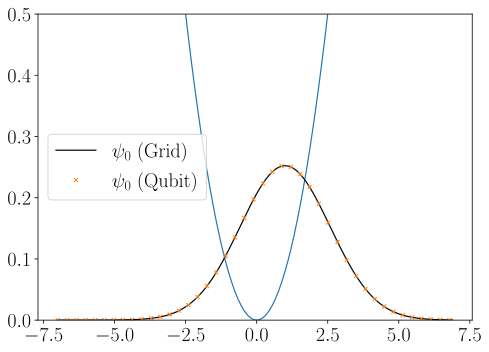

In [19]:
plt.figure()
plt.plot(qubit_testbed.x_grid, qubit_testbed._PE_grid)
plt.plot(qubit_testbed.x_grid, 
         np.real(qubit_testbed.psio_grid.conj() * qubit_testbed.psio_grid), 
         color='k', label=r'$\psi_{0}$ (Grid)')
plt.plot(qubit_testbed.x_grid, 
         np.real(qubit_testbed.dynamics_results_qubit[0].conj() * 
                 qubit_testbed.dynamics_results_qubit[0].conj())/qubit_testbed.dx, 
         marker='x', lw=0, markevery=3, label=r'$\psi_{0}$ (Qubit)')
plt.ylim(0, 0.5)
plt.legend()
# plt.title('')

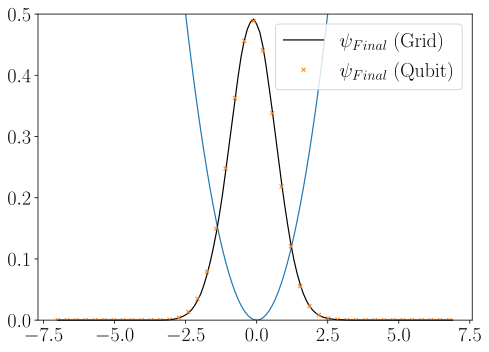

In [20]:
plt.figure()
plt.plot(qubit_testbed.x_grid, qubit_testbed._PE_grid)
plt.plot(qubit_testbed.x_grid, 
         np.abs(qubit_testbed.dynamics_results_grid[-1].conj() * qubit_testbed.dynamics_results_grid[-1]), 
         color='k', label=r'$\psi_{Final}$ (Grid)')
plt.plot(qubit_testbed.x_grid, 
         np.abs(qubit_testbed.dynamics_results_qubit[-1].conj() * 
                 qubit_testbed.dynamics_results_qubit[-1].conj())/qubit_testbed.dx, 
         marker='x', lw=0, markevery=3, label=r'$\psi_{Final}$ (Qubit)')
plt.ylim(0, 0.5)
plt.legend()
# plt.title('')

## Example for Running Calculation on Real IBM Device

In [21]:
# To use a real backend: 
from qiskit_ibm_runtime import QiskitRuntimeService
# # If you did not previously save your credentials, use the following line:
MY_API_TOKEN="MY_API_TOKEN"
service = QiskitRuntimeService(channel="ibm_quantum", token=MY_API_TOKEN, instance='ibm-q/open/main')
# Save your credentials:
service.save_account(name='b-ibmq', token=MY_API_TOKEN, channel='ibm_quantum', overwrite=True)
backend = service.least_busy(simulator=False, operational=True)
qubit_testbed.propagate_qSOFT(backend_specification=backend)

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

## Code for running things with a realistic noise model

```python

from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

service = QiskitRuntimeService()
 
# Specify a QPU to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qubit_testbed.quantum_circuit)
sampler = Sampler(mode=aer)
result = sampler.run([qubit_testbed.quantum_circuit]).result()
```

## Harmonic Oscillator

In [22]:
# Instantiate our Closed-Systems Dynamics Class
test = QFlux_CS(n_basis=128, xo=1.0, po=0.0, mass=1.0, omega=1.0)
# Define our coordinate x and p operators
test.set_coordinate_operators()
# Initialize the ladder operators
test.initialize_operators()

In [23]:
# Define the default initial state (note that custom initialization is also supported)
test.set_initial_state()

In [24]:
# Define some parameters for the propagation
total_time = 20.0
N_steps = 400
test.set_propagation_time(total_time, N_steps)

In [25]:
# Set the Potential/Hamiltonian for our object, in this case using the pre-defined 'harmonic' oscillator potential
test.set_hamiltonian(potential_type='harmonic')

In [26]:
# Propagate with SOFT and QuTiP
test.propagate_SOFT()

In [27]:
test.propagate_qt()

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.02s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.03s. Est. time left: 00:00:00:00
50.1%. Run time:   0.04s. Est. time left: 00:00:00:00
60.2%. Run time:   0.05s. Est. time left: 00:00:00:00
70.2%. Run time:   0.05s. Est. time left: 00:00:00:00
80.2%. Run time:   0.06s. Est. time left: 00:00:00:00
90.2%. Run time:   0.07s. Est. time left: 00:00:00:00
100.0%. Run time:   0.07s. Est. time left: 00:00:00:00
Total run time:   0.07s


Text(0, 0.5, '$V(x)$')

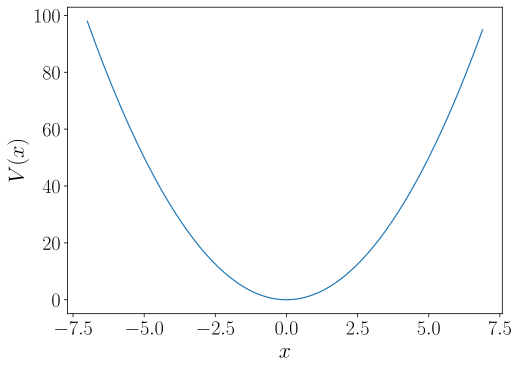

In [28]:
plt.plot(test.x_grid, test._PE_grid)
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')

In [29]:
exp_x_qt = qt.expect(test.x_op, test.dynamics_results_op.states)
exp_p_qt = qt.expect(test.p_op, test.dynamics_results_op.states)

exp_x_ana = [ test.xo*np.cos(test.omega*t) + (test.po/test.mass/test.omega)*np.sin(test.omega*t) for t in test.tlist]
exp_p_ana = [ test.po*np.cos(test.omega*t) -test.xo*test.omega*test.mass*np.sin(test.omega*t)  for t in test.tlist]

(0.0, 20.0)

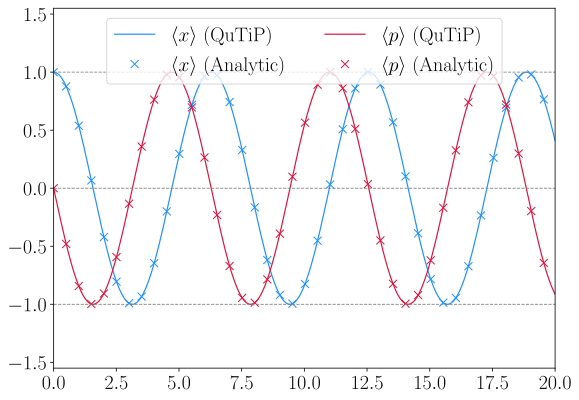

In [30]:
# Plot expectation value, compare to analytic expression
plt.figure(figsize=(9, 6.5))
plt.plot(test.tlist, exp_x_qt, label=r'$\left\langle x \right\rangle$ (QuTiP)', color='dodgerblue')
plt.plot(test.tlist, exp_x_ana, label=r'$\left\langle x \right\rangle$ (Analytic)', 
         lw=0, marker='x', markevery=10, color='dodgerblue', ms=8)
plt.plot(test.tlist, exp_p_qt, label=r'$\left\langle p \right\rangle$ (QuTiP)', color='crimson')
plt.plot(test.tlist, exp_p_ana, label=r'$\left\langle p \right\rangle$ (Analytic)', 
         lw=0, marker='x', markevery=10, color='crimson', ms=8)
plt.ylim(-1.55, 1.55)

plt.legend(ncols=2, loc='upper center')
plt.hlines([-1, 0, 1], min(test.tlist), max(test.tlist), ls='--', lw=0.85, color='tab:grey', zorder=2)
plt.xlim(min(test.tlist), max(test.tlist))

## Adenine-Thymine

In [31]:
from utils import * 

In [32]:
def calculate_expectation_values(dynamics_results, observable_grid, do_FFT=False, dx=None):
    '''
    Function to calculate the time-dependent expectation value of an observable O defined on a grid.
    Inputs:

        - `dynamics_results`: np.ndarray of wavefunctions/propagated states with shape: (n_steps, nx)
        - `observable_grid`: np.array of observable
    '''
    if dx:
        d_observable = dx
    else:
        d_observable = observable_grid[1] - observable_grid[0]
    if do_FFT:
        psi_list = np.fft.fft(dynamics_results, axis=1, norm='ortho')
    else:
        psi_list = dynamics_results
    # Compute the expectation value.
    expectation  = np.real(np.sum(psi_list.conj()*observable_grid*psi_list*d_observable, axis=1))

    return(expectation)

ev2au = convert_eV_to_au(1.0)
def get_doublewell_potential_second_deriv(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    return f*(2*a2/x0**2 + 6*a3*x/x0**3 + 12*a4*x**2/x0**4)


def get_doublewell_potential(x, x0=1.9592, f=ev2au, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/x0
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

In [33]:
proton_mass = get_proton_mass()
x0 = 1.9592
omega = np.sqrt(get_doublewell_potential_second_deriv(x0)/proton_mass)

test = QFlux_CS(n_basis=128, xo=1.5*x0, mass=proton_mass, omega=omega)

test.set_coordinate_operators(x_min=-4.0, x_max=4.0)
test.initialize_operators()
test.set_initial_state(wfn_omega=omega)

total_time = convert_fs_to_au(30.0)
N_steps = 3000
test.set_propagation_time(total_time, N_steps)
test.set_hamiltonian(potential_type='quartic')
# frequency corresponding to the right well (in atomic units)
test.propagate_SOFT()
test.propagate_qt()

10.0%. Run time:   0.22s. Est. time left: 00:00:00:02
20.0%. Run time:   0.51s. Est. time left: 00:00:00:02
30.0%. Run time:   0.79s. Est. time left: 00:00:00:01
40.0%. Run time:   1.08s. Est. time left: 00:00:00:01
50.0%. Run time:   1.36s. Est. time left: 00:00:00:01
60.0%. Run time:   1.65s. Est. time left: 00:00:00:01
70.0%. Run time:   1.92s. Est. time left: 00:00:00:00
80.0%. Run time:   2.17s. Est. time left: 00:00:00:00
90.0%. Run time:   2.39s. Est. time left: 00:00:00:00
100.0%. Run time:   2.59s. Est. time left: 00:00:00:00
Total run time:   2.59s


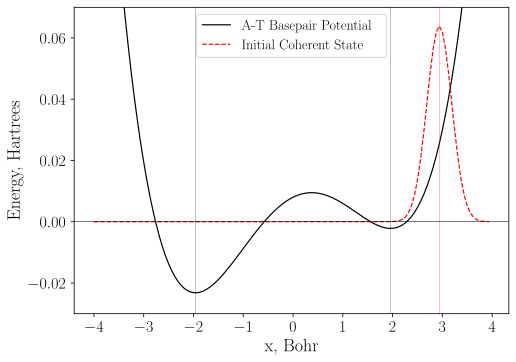

In [34]:
# checking potential and initial coherent state
fig, ax = plt.subplots(dpi=300)
ax.plot(test.x_grid, test._PE_grid  - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T Basepair Potential')
ax.plot(test.x_grid, np.real(0.04*test.psio_grid.conj()*test.psio_grid),'--',color='red',label='Initial Coherent State')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-test.x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(test.x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(test.x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('x, Bohr',fontsize=18)
ax.set_ylabel('Energy, Hartrees',fontsize=18)
ax.tick_params(labelsize=16, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=14,loc='upper center')
plt.show()

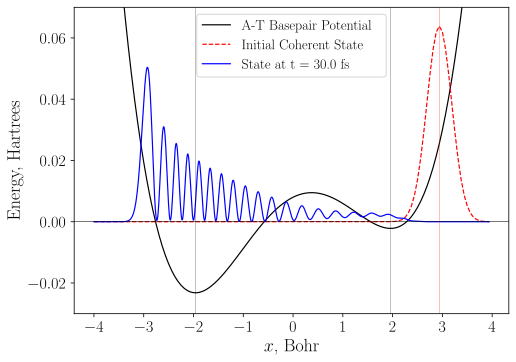

In [35]:
from scipy.interpolate import interp1d

x_1024 = np.linspace(test.x_grid[0], test.x_grid[-1], 1024)
f_interp = interp1d(test.x_grid, test.dynamics_results_grid[-1], kind='cubic')
rho_interp = f_interp(x_1024)

fig, ax = plt.subplots()
ax.plot(test.x_grid, test._PE_grid  - get_doublewell_potential(x0) - omega/2, '-',color='black',label='A-T Basepair Potential')
ax.plot(test.x_grid, 0.04*np.real(test.psio_grid.conj()*test.psio_grid),'--',color='red',label='Initial Coherent State')
ax.plot(x_1024, 0.04*np.real(rho_interp.conj()*rho_interp),'-',color='blue',label=f'State at t = {convert_au_to_fs(total_time)} fs')
ax.axhline(0, lw=0.5, color='black', alpha=1.0)
ax.axvline(-x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0, lw=0.5, color='black', alpha=0.5)
ax.axvline(x0*1.5, lw=0.5, color='red', alpha=0.5)
ax.set_xlabel('$x$, Bohr',fontsize=18)
ax.set_ylabel('Energy, Hartrees',fontsize=18)
ax.tick_params(labelsize=16, grid_alpha=0.5)
plt.ylim(-0.03,0.07)
plt.legend(fontsize=14,loc='upper center')
plt.show()

## Custom Potential

In [36]:
# Morse Potential
def morse_potential(x_eq=None, mass=None, omega=None, xval=None):
    De = 8
    k = mass*omega**2
    a = np.sqrt(k/(2*De))
    y = De * ((1 - np.exp(-a*(xval-x_eq)))**2)
    return(y)

In [37]:
x_arr = np.linspace(-3, 3)
xo    = -1.0
mass  = 1.0
omega = 1.0


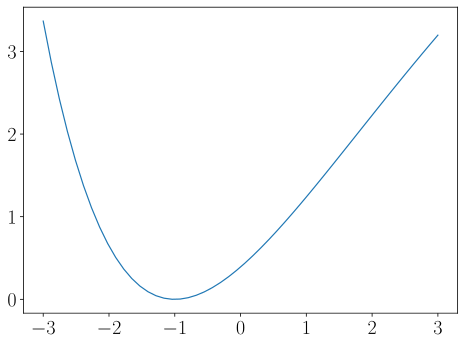

In [38]:
plt.plot(x_arr, morse_potential(xo, mass, omega, x_arr))

In [39]:
test = QFlux_CS(n_basis=128, xo=-1.0, mass=1.0, omega=1.0)

test.set_coordinate_operators(x_min=-3.0, x_max=3.0)
test.initialize_operators()
test.set_initial_state()

total_time = convert_fs_to_au(1.0)
N_steps = 4000
test.set_propagation_time(total_time, N_steps)

In [40]:
custom_func = morse_potential
custom_func_kwargs = {'x_eq' : -1.0, 'mass' : test.mass, 
                      'omega' : test.omega, 'xval' : test.x_grid}
# x_eq=None, mass=None, omega=None, xval=None
test.set_H_grid_with_custom_potential(morse_potential, **custom_func_kwargs)

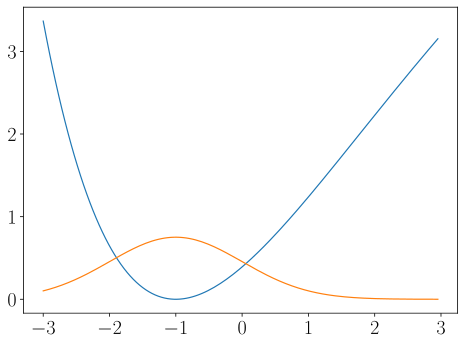

In [41]:
plt.figure()
plt.plot(test.x_grid, test._PE_grid.real)
plt.plot(test.x_grid, abs(test.psio_grid))

In [42]:
# Define the function for an operator... 
def morse_potential_op(x_eq=None, mass=None, omega=None, xval=None):
    De = 8
    k = mass*omega**2
    a = np.sqrt(k/(2*De))
    exponential_f = (-a * (xval - x_eq)).expm()
    y = De * ((1 - exponential_f)**2)
    return(y)

In [43]:
custom_func_kwargs = {'x_eq' : -1.0, 'mass' : 1.0, 
                      'omega' : 1.0, 'xval' : test.x_op}
test.set_H_op_with_custom_potential(morse_potential_op, **custom_func_kwargs)

In [44]:
test.propagate_SOFT()

In [45]:
test.propagate_qt(solver_options={'nsteps': len(test.tlist)})

10.0%. Run time:  12.81s. Est. time left: 00:00:01:55
20.0%. Run time:  29.05s. Est. time left: 00:00:01:56
30.0%. Run time:  45.22s. Est. time left: 00:00:01:45
40.0%. Run time:  59.40s. Est. time left: 00:00:01:29
50.0%. Run time:  73.08s. Est. time left: 00:00:01:13
60.0%. Run time:  86.04s. Est. time left: 00:00:00:57
70.0%. Run time:  98.78s. Est. time left: 00:00:00:42
80.0%. Run time: 116.90s. Est. time left: 00:00:00:29
90.0%. Run time: 132.22s. Est. time left: 00:00:00:14
100.0%. Run time: 147.37s. Est. time left: 00:00:00:00
Total run time: 147.37s


/Users/bcallen/miniforge3/envs/QFlux_Env/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bcallen/miniforge3/envs/QFlux_Env/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


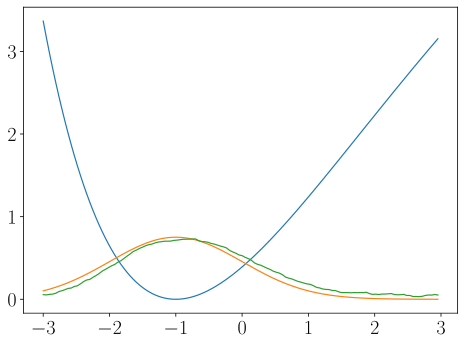

In [46]:
plt.figure()
plt.plot(test.x_grid, test._PE_grid)
plt.plot(test.x_grid, test.psio_grid)
plt.plot(test.x_grid, np.abs(test.dynamics_results_grid[-1]))

In [52]:
exp_x_qt = qt.expect(test.x_op, test.dynamics_results_op.states)
exp_p_qt = qt.expect(test.p_op, test.dynamics_results_op.states)



(0.0, 41.3414)

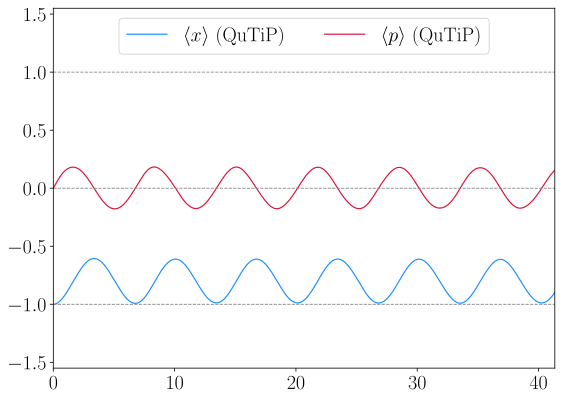

In [54]:
# Plot expectation value, compare to analytic expression
plt.figure(figsize=(9, 6.5))
plt.plot(test.tlist, exp_x_qt, label=r'$\left\langle x \right\rangle$ (QuTiP)', color='dodgerblue')
plt.plot(test.tlist, exp_p_qt, label=r'$\left\langle p \right\rangle$ (QuTiP)', color='crimson')
plt.ylim(-1.55, 1.55)

plt.legend(ncols=2, loc='upper center')
plt.hlines([-1, 0, 1], min(test.tlist), max(test.tlist), ls='--', lw=0.85, color='tab:grey', zorder=2)
plt.xlim(min(test.tlist), max(test.tlist))